# Problem set 2 (45 + 50 + 33 + 15 = 143 pts)

In [ ]:
import timeit
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.linalg import lu as scipy_lu, cholesky as scipy_cholesky, pascal

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/Colab Notebooks/Numerical Linear Algebra'

/content/gdrive/MyDrive/Colab Notebooks/Numerical Linear Algebra


## Problem 1 (LU decomposition) 45 pts


### 1. LU  for band matrices and Cholesky decomposition (13 pts)

The complexity to find an LU decomposition of a dense $n\times n$ matrix is $\mathcal{O}(n^3)$.
Significant reduction in complexity can be achieved if the matrix has a certain structure, e.g. it is sparse. 
In the following task we consider an important example of $LU$ for a special type of matrices –– band matrices with top left entry equal to 1 and the bandwidth $m$ equal to 3 or 5 which called tridiagonal and pentadiagonal respectively. The bands may be ```[1, 2, 1]``` and ```[1, 1, 2, 1, 1]``` respectively

- (4 pts) Write a function ```band_lu(diag_broadcast, n)``` which computes LU decomposition for tridiagonal or pentadiagonal matrix with top left entry equal to 1 with given diagonal bands. 
For example, input parametres ```(diag_broadcast = [1,2,1], n = 4)``` mean that we need to find LU decomposition for the triangular matrix of the form:

$$A = \begin{bmatrix}
1 & 1 & 0 & 0\\
1 & 2 & 1 & 0 \\
0 & 1 & 2 & 1 \\
0 & 0 & 1 & 2 \\
\end{bmatrix}.$$

Provide the extensive testing of the implemented function that will works correctly for large $n$,  e.g. $n=100$.
As an output it is considered to make ```L``` and ```U``` - 2D arrays representing diagonals in factors $L$ (```L[0]``` keeps first lower diagonal, ```L[1]``` keeps second lower, ...), and $U$ (```U[:,0]``` keeps main diagonal, ```U[:,1]``` keeps first upper, ...).

- (2 pts) Compare execution time of the band LU decomposition using standard function from ```scipy```, i.e. which takes the whole matrix and does not know about its special structure, and band decomposition of yours implementation. Comment on the results.

- (7 pts) Write a function ```cholesky(n)``` for computing Cholesky decomposition. It should take the the single argument - the matrix that will be factorized and return the single output - lower-triangular factor $L$. Think about the efficiency of your implementation and if necessary update it to achieve the best performance (eliminate Python loops, where it is possible and so on). Explicitly describe the difference with LU decomposition that reduces the complexity from $2n^3/3$ for LU to $n^3/3$ for Cholesky. 
Test the implemented function on the Pascal matrix of given size $n$ for $n = 5, 10, 50$. 
Pascal matrix is square matrix of the following form (here for $n=4$)
$$P = \begin{bmatrix}
1 & 1 & 1 & 1\\
1 & 2 & 3 & 4 \\
1 & 3 & 6 & 10 \\
1 & 4 & 10 & 20 \\
\end{bmatrix}.$$

    [Here](https://en.wikipedia.org/wiki/Pascal_matrix) you can find more details about such matrices and analytical form for factor $L$ from Cholesky decomposition. Compare the result of your implementation with analytical expression in terms of some matrix norm of difference.  

In [ ]:
def get_matrix_from_broadcast(diag_broadcast, n):
    A = np.zeros((n, n))
    shift = len(diag_broadcast) // 2

    for i in range(len(diag_broadcast)):
        band = diag_broadcast[i] * np.ones(n - abs(i - shift))
        A += np.diag(band, i - shift)
    
    A[0, 0] = 1
    return A

In [ ]:
def get_matrix_from_band_lu(L_diag, U_diag):
    n = U_diag.shape[0]
    L, U = np.identity(n), np.zeros((n, n))
    
    for i, d in enumerate(L_diag):
        L += np.diag(d[:len(d) - i], -(i + 1))
        
    for i, d in enumerate(U_diag.T):
        U += np.diag(d[:len(d) - i], i)
    
    return L @ U

In [ ]:
diag_broadcast, n = [1, 3, 2], 8

Basic LU decomposition is constructed from the sequence of Guassian elimination snapshots $U_k$, where the first $k$ columns under the diagonal  equal to zero, and the lower triangular matrices $L_k$ which provide the elimination of $k$ 'th column under the diagonal of matrix 
$U_{k - 1}$ and yield new matrix $U_k$, so the final snapshot $U_{n - 1} = U$ is an upper triangular matrix
$$U_0 = A \Longrightarrow \forall k \geqslant 0: L_{k + 1} U_k = U_{k + 1}$$

We can describe the process as
$$\left[\prod_{k = 1}^{n - 1}L_{n - k}\right] A = \left[\prod_{k = 1}^{n - 1}L_{n - k}\right] U_0 = 
\left[\prod_{k = 1}^{n - 2}L_{n - k}\right] U_1 = \dots = L_{n - 1} U_{n - 2} = U_{n - 1} = U$$
<!-- $$L_{n - 1} L_{n - 2} \dots L_1 A = L_{n - 1} L_{n - 2} \dots L_1 U_0 = L_{n - 1} L_{n - 2} \dots L_2 U_1 = 
\dots = L_{n - 1} U_{n - 2} = U_{n - 1} = U$$ -->
$$A = \left[\prod_{k = 1}^{n - 1}L_{n - k}\right]^{-1}\!\!\!\! U = \left[\prod_{k = 1}^{n - 1}L_k^{-1}\right] U = LU$$
<!-- $$A = L_1^{-1}L_2^{-1} \dots L_{n - 1}^{-1}U = LU$$ -->

Finally, we can notice that the matrix $L_k^{-1}$ contains the eliminating column from $L_k$, but with the opposite sign 
(if the elimination step is performed by subtracting some row, we can invert this step by adding it back)

In [ ]:
def fast_lu(A):
    n = A.shape[0]
    L = np.identity(n)
    U = A.copy()

    for j in range(n - 1):

        # define proper coefficients for reverting row operations and put them into matrix L
        eliminating_coefficients = U[j + 1:, j] / U[j, j]
        L[j + 1:, j] = eliminating_coefficients

        # perform one step of Gaussian elimination — zero out j'th column under j'th row in matrix A
        U[j + 1:, :] = U[j + 1:, :] - eliminating_coefficients.reshape(-1, 1) * U[j, :]
    
    return L, U

In [ ]:
A = get_matrix_from_broadcast(diag_broadcast, n)
L, U = fast_lu(A)
np.allclose(L @ U, A)

True

What changes in the LU decomposition for matrix with band of width $2m + 1$ is that the eliminating matrix $L$ contains up to $m$ non-zero 
values beyond the main diagonal, while the resulting matrix $U$ — up to $m$ non-zero values above the main diagonal. Moreover, we can employ the fact that the vertical slice of the matrix $A$ always has the same form (contains the same values in specific order).

In [ ]:
# INPUT : diag_broadcast - list of diagonals value to broadcast, length equal to 3 or 5
#         n - integer, band matrix shape
# 
# OUTPUT : L - 2D np.ndarray, L.shape[0] depends on bandwidth, L.shape[1] = n - 1, do not store main diagonal, where all ones
#          add zeros to the right side of rows to handle with changing length of diagonals
# 
#          U - 2D np.ndarray, U.shape[0] = n, U.shape[1] depends on bandwidth
#          add zeros to the bottom of columns to handle with changing length of diagonals

def band_lu(diag_broadcast, n):
    band_width = len(diag_broadcast)
    L = np.zeros(
        ((band_width - 1) // 2, n - 1)
    )
    U = np.zeros(
        (n, (band_width + 1) // 2)
    )
    U[0, 0] = 1

    if band_width == 3:
        for i in range(n - 1):
            U[i, 1] = diag_broadcast[2]

            L[0, i] = diag_broadcast[0] / U[i, 0]
            U[i + 1, 0] = diag_broadcast[1] - L[0, i] * U[i, 1]

    elif band_width == 5:
        L[0, 0] = diag_broadcast[1] / U[0, 0]

        U[0, 1] = diag_broadcast[3]
        U[1, 0] = diag_broadcast[2] - L[0, 0] * U[0, 1]

        for i in range(1, n - 1):
            U[i - 1, 2] = diag_broadcast[4]
            U[i, 1] = diag_broadcast[3] - L[0, i - 1] * U[i - 1, 2]

            L[1, i - 1] = diag_broadcast[0] / U[i - 1, 0]
            L[0, i] = (diag_broadcast[1] - L[1, i - 1] * U[i - 1, 1]) / U[i, 0]
            U[i + 1, 0] = diag_broadcast[2] - L[1, i - 1] * U[i - 1, 2] - L[0, i] * U[i, 1]

    return L, U

* check whether the implementation is correct

In [ ]:
nn = np.logspace(1, 4, 20).astype('int')

for n in tqdm(nn):
    diag_broadcast = np.random.randn(3)
    L, U = band_lu(diag_broadcast, n)
    assert np.allclose(get_matrix_from_broadcast(diag_broadcast, n), get_matrix_from_band_lu(L, U))

100%|██████████| 20/20 [01:27<00:00,  4.37s/it]


In [ ]:
nn = np.logspace(1, 4, 20).astype('int')

for n in tqdm(nn):
    diag_broadcast = np.random.randn(5)
    L, U = band_lu(diag_broadcast, n)
    assert np.allclose(get_matrix_from_broadcast(diag_broadcast, n), get_matrix_from_band_lu(L, U))

100%|██████████| 20/20 [01:30<00:00,  4.51s/it]


* plot execution time

In [ ]:
execution_scipy_3d, execution_band_3d = [], []
execution_scipy_5d, execution_band_5d = [], []

nn = np.logspace(1, 3, 20).astype('int')

for n in tqdm(nn):
    # for 3 diagonals
    diag_broadcast = np.random.randn(3)

    time = timeit.timeit(lambda: band_lu(diag_broadcast, n), number=10) / 10
    execution_band_3d.append(time)
    
    A = get_matrix_from_broadcast(diag_broadcast, n)
    time = timeit.timeit(lambda: scipy_lu(A), number=10) / 10
    execution_scipy_3d.append(time)
    
    # for 5 diagonals
    diag_broadcast = np.random.randn(5)

    time = timeit.timeit(lambda: band_lu(diag_broadcast, n), number=10) / 10
    execution_band_5d.append(time)
    
    A = get_matrix_from_broadcast(diag_broadcast, n)
    time = timeit.timeit(lambda: scipy_lu(A), number=10) / 10
    execution_scipy_5d.append(time)

100%|██████████| 20/20 [00:06<00:00,  3.04it/s]


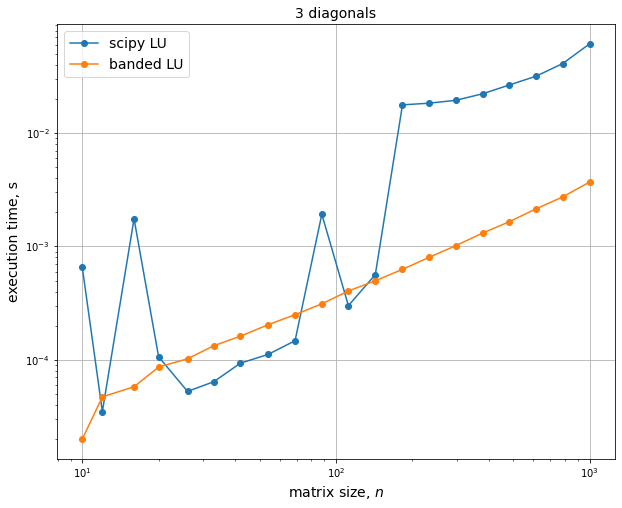

In [ ]:
plt.figure(figsize=(10, 8))

plt.plot(nn, execution_scipy_3d, label='scipy LU', marker='o')
plt.plot(nn, execution_band_3d, label='banded LU', marker='o')
plt.xlabel('matrix size, $n$', fontsize=14)
plt.ylabel('execution time, s', fontsize=14)

plt.yscale('log')
plt.xscale('log')

plt.legend(fontsize=14)
plt.title('3 diagonals', fontsize=14)
plt.grid()
plt.show()

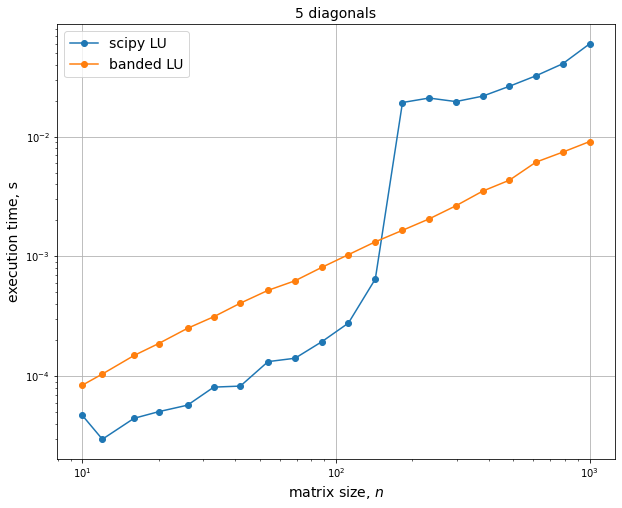

In [ ]:
plt.figure(figsize=(10, 8))

plt.plot(nn, execution_scipy_5d, label='scipy LU', marker='o')
plt.plot(nn, execution_band_5d, label='banded LU', marker='o')
plt.xlabel('matrix size, $n$', fontsize=14)
plt.ylabel('execution time, s', fontsize=14)

plt.yscale('log')
plt.xscale('log')

plt.legend(fontsize=14)
plt.title('5 diagonals', fontsize=14)
plt.grid()
plt.show()

As it was expected, we can see non-linear (cubic) dependence of computational time on matrix size $n$ for scipy implementation and linear dependence for our structure-aware implementation.

<!-- The dependencies for scipy implementation is the same for both 3-diagonal and 5-diagonal matrices since the algorithm doesn't utilize the matrix structure. However, they vary for our implementations, as the 5-diagonal case requires more operations. -->

In [ ]:
def cholesky(A):
    n = A.shape[0]
    L = np.zeros((n, n))

    for i in range(n):
        L[i, i] = np.sqrt(A[i, i] - np.sum(L[i, :i] ** 2))
        L[i + 1:, i] = (A[i + 1:, i] - np.sum(L[i + 1:, :i] * L[i, :i].reshape(1, -1), axis=1)) / L[i, i]
    
    return L

According to https://rosettacode.org/wiki/Pascal_matrix_generation, Cholesky factor of Pascal matrix is the same Pascal matrix in 
the lower triangular form

In [ ]:
pascal_matrix = pascal(10)
pascal_cholesky_factor = pascal(10, kind='lower')
not np.any(pascal_matrix - pascal_cholesky_factor @ pascal_cholesky_factor.T)

True

In [ ]:
nn = np.arange(5, 51, 5).astype('int')
cholesky_errors_custom, cholesky_errors_scipy = [], []

for n in tqdm(nn):
    pascal_matrix = pascal(n).astype('float64')
    pascal_cholesky_factor = pascal(n, kind='lower').astype('float64')

    L = cholesky(pascal_matrix)
    cholesky_errors_custom.append(np.linalg.norm(L - pascal_cholesky_factor))

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
100%|██████████| 10/10 [00:00<00:00, 298.08it/s]


In [ ]:
cholesky_errors_custom

[0.0, 0.0, 0.0, 0.0, 0.0, 6.559982504009003, nan, nan, nan, nan]

Given the list of Frobenius norms of difference between custom Cholesky factors and the actual Pascal factors, it can be seen that numerical instability leads to significant errors at some point, making it impossible to perform decomposition even for scipy

In [ ]:
try:
    L = scipy_cholesky(pascal_matrix)
    cholesky_errors_scipy.append(np.linalg.norm(L - pascal_cholesky_factor))
except Exception as exception:
    print(exception)

31-th leading minor of the array is not positive definite


The computational cost of Cholesky decomposition is reduced comparing to LU decomposition. In particular, for some elimination step $k$, 
LU decomposition requires $n - k + 1$ additions and $n - k + 1$ multiplications over $n − k$ rows

$$T_{\text{LU}}(n) = \sum\limits_{k = 1}^n 2\big[n - k + 1\big]\big[n - k\big] = 
\sum\limits_{m = 1}^n 2m\big[m - 1\big] = 2\left[\sum\limits_{m = 1}^n m^2 - \sum\limits_{m = 1}^n m\right] = \frac{2n^3}{3} + O(n^2)$$

At the same time, for some iteration $k$, Cholesky decomposition requires $k - 1$ multiplications, $k - 1$ subtractions and 
$1$ division (or root extraction) over $n - k + 1$ rows

$$T_{\text{Cholesky}}(n) = \sum\limits_{k = 1}^n \big[n - k + 1\big]\big[2k - 1\big] = 
\sum\limits_{k = 1}^n \Big[\big[2n + 3\big]k - 2k^2 - n - 1\Big] = $$
$$= 2n\sum\limits_{k = 1}^n k - 2\sum\limits_{k = 1}^n k^2 + O(n^2) = 
n^3 - \frac{2n^3}{3} + O(n^2) = \frac{n^3}{3} + O(n^2)$$

### 2. Stability of LU (8 pts)

* (4 pts) Show, that for these  matrices $A$ and $B$ LU decomposition fails. Why does it happen?

For matrix $A$ the first step of Gaussian eliminations fails because the pivot element is zero
$$A = \begin{bmatrix}
0 & 1 \\
2 & 3
\end{bmatrix}$$

For matrix $B$ the second step fails due to the singularity of the second leading principal minor

$$B = \begin{bmatrix}
1 & 1 & 0\\
1 & 1 & 2 \\
1 & 2 & 1
\end{bmatrix} \longrightarrow 
\begin{bmatrix}
1 & 1 & 0\\
0 & 0 & 2 \\
0 & 1 & 1
\end{bmatrix}
$$

* (4 pts) In the LU decomposition, a pivot position is a position of the element that identifies the row and column that will be eliminated in the current step. For example, first pivot in LU is usually the left top element. What value of $c$ leads to zero in the second pivot position? What $c$ produces zero in the third pivot position? What modification of LU should we use in order to address the possible zeros in pivot position?

$$A = \begin{bmatrix}
1 & c & 0\\
2 & 4 & 1 \\
3 & 5 & 1
\end{bmatrix} \longrightarrow 
\begin{bmatrix}
1 & c & 0\\
0 & 4 - 2c & 1 \\
0 & 5 - 3c & 1
\end{bmatrix} \longrightarrow 
\begin{bmatrix}
1 & c & 0\\
0 & 4 - 2c & 1 \\
0 & 0 & 1 - \cfrac{5 - 3c}{4 - 2c}
\end{bmatrix}
$$

Here $c = 2$ produces zero in the second zero position and $c = 1$ leads to zero in the third pivot position. In order to avoid failing 
Gaussian elimination, we need to perform permutation of rows or columns in matrix $A$ so that the pivot element would be also non-zero. Such transformation $P$ can be applied to the original matrix $A$, which leads to the following form of decomposition with row permutation

$$PA = LU \Longrightarrow A = P^{-1}LU$$

or with column permutation

$$AP = LU \Longrightarrow A = LUP^{-1}$$

In particular, here we can use the following column permutation
$$P = \begin{bmatrix}
1 & 0 & 0\\
0 & 0 & 1 \\
0 & 1 & 0
\end{bmatrix} \Longrightarrow AP = \begin{bmatrix}
1 & c & 0\\
2 & 4 & 1 \\
3 & 5 & 1
\end{bmatrix}\begin{bmatrix}
1 & 0 & 0\\
0 & 0 & 1 \\
0 & 1 & 0
\end{bmatrix} = \begin{bmatrix}
1 & 0 & c\\
2 & 1 & 4 \\
3 & 1 & 5
\end{bmatrix}$$

### 3. Implementation of PLU decomposition (14 pts)

As you have noticed before, LU decomposition may fail. In order to make it stable, we can use LU decomposition with pivoting  (PLU).

We want to find such permutation matrix $P$ that LU decomposition of $PA$ exists

$$ PA = LU $$

- (7 pts) Implement efficiently PLU decomposition (without loops and with appropriate level of BLAS operations).  Also, pay attention to the way of permutation matrix storage.

- (4 pts ) Compare your function for computing PLU with built-in function on matrices of such type ```(mirror_diag = [1,2,1], n = 4)```. (Bandwidth and matrix size may vary). So, you can pass them as dense 2D NumPy array and do not tune your implementation to this special structure. Compare them in terms of running time (use ```%timeit``` magic) for range of dimensions to recover the asymptotic rate of time increasing and in terms of acuracy. We expect you plot the running time vs matrix dimension for built-in function and your implementation. So you should get the plot with two lines.
Consider additionally one of the pathological examples from above, where LU fails, but PLU has to work.


$$A = \begin{bmatrix}
0 & 0 & 1 & 1 \\
 0 &1 & 2 & 1  \\
 1 & 2 & 1  & 0\\
1 & 2  & 0 & 0  \\
\end{bmatrix}.$$


- (3 pts) Discuss the obtained results and explain how is it possible to accelerate computing the PLU factorization. 

NumPy or JAX are both ok in this problem, but please use the single library for all implementations. 

In PLU decomposition we have some changes

$$\left[\prod_{k = 1}^{n - 1}L_{n - k}P_{n - k}\right] A = \left[\prod_{k = 1}^{n - 1}L_{n - k}P_{n - k}\right] U_0 = 
\left[\prod_{k = 1}^{n - 2}L_{n - k}P_{n - k}\right] U_1 = \dots = L_{n - 1} P_{n - 1} U_{n - 2} = U_{n - 1} = U$$
<!-- $$L_{n - 1} L_{n - 2} \dots L_1 A = L_{n - 1} L_{n - 2} \dots L_1 U_0 = L_{n - 1} L_{n - 2} \dots L_2 U_1 = 
\dots = L_{n - 1} U_{n - 2} = U_{n - 1} = U$$ -->
<!-- $$A = \left[\prod_{k = 1}^{n - 1}L_{n - k}P_{n - k}\right]^{-1}\!\!\!\! U = \left[\prod_{k = 1}^{n - 1}P_k L_k^{-1}\right] U = PLU$$ -->
<!-- $$A = L_1^{-1}L_2^{-1} \dots L_{n - 1}^{-1}U = LU$$ -->

The last transition is not obvious, so we can demonstrate it using the following trick
$$\forall j: P_j^{-1} = P_j,\;P_jP_j = I \Longrightarrow 
\prod_{k = 1}^{n - 1}L_{n - k}P_{n - k} = L_{n - 1}P_{n - 1} \dots \Big[L_2 P_2\Big] \Big[L_1 P_1\Big] =$$
$$= L_{n - 1}P_{n - 1} \dots \Big[L_2 P_2\Big] \Big[L_1 P_2 P_2 P_1\Big] = L_{n - 1}P_{n - 1} \dots L_2 \Big[P_2 L_1 P_2\Big] P_2 P_1 = 
L_{n - 1}P_{n - 1} \dots L_2 \widetilde{L}_1 P_2 P_1$$

Since multiplication of elimination metrix $L_k$ by any permutation matrix $P_j$ for $j > k$ from both sides leads to moving ones along 
the diagonal and permutation of corresponding values in $k$'th column of $L_k$ (leaving it lower diagonal with the same structure), 
we can conclude
$$\forall k > 1: \widetilde{L}_k = \widetilde{P}_{k + 1}L_k\widetilde{L}_{k - 1}\widetilde{P}_{k + 1}$$

This fact enables us to write the following expression
$$\prod_{k = 1}^{n - 1}L_{n - k}P_{n - k} = \prod_{k = 1}^{n - 1}\widetilde{L}_{n - k}\prod_{k = 1}^{n - 1}P_{n - k} = LP$$
$$PA = \left[\prod_{k = 1}^{n - 1}P_{n - k}\right]A = \left[\prod_{k = 1}^{n - 1}\widetilde{L}_{n - k}\right]^{-1}\!\!\!\! U = 
\left[\prod_{k = 1}^{n - 1}\widetilde{L}_k^{-1}\right] U = LU$$

In [ ]:
def fast_plu(A):
    n = A.shape[0]
    L = np.identity(n)
    U = A.copy()
    permutation = np.arange(0, n)

    for j in range(n - 1):

        # perform proper row permutation in matrices U and L
        max_row_idx = np.argmax(np.abs(U[j:, j])) + j
        permutation[[j, max_row_idx]] = permutation[[max_row_idx, j]]
        U[[j, max_row_idx]] = U[[max_row_idx, j]]
        L[[j, max_row_idx], :j] = L[[max_row_idx, j], :j]

        # define proper coefficients for reverting row operations and put them into matrix L
        eliminating_coefficients = U[j + 1:, j] / U[j, j]
        L[j + 1:, j] = eliminating_coefficients

        # perform one step of Gaussian elimination — zero out j'th column under j'th row in matrix A
        U[j + 1:, :] = U[j + 1:, :] - eliminating_coefficients.reshape(-1, 1) * U[j, :]
    
    return permutation, L, U

In [ ]:
def get_matrix_from_plu(permutation, L, U):
    P = np.identity(len(permutation))

    return np.linalg.inv(P[permutation]) @ L @ U

In [ ]:
# A = np.random.rand(1000, 1000)
A = np.flip(get_matrix_from_broadcast(diag_broadcast, 100), 1)
permutation, L, U = fast_plu(A)
np.allclose(get_matrix_from_plu(permutation, L, U), A)

True

In [ ]:
execution_scipy_plu, execution_custom_plu = [], []
nn = np.logspace(1, 3, 20).astype('int')

for n in tqdm(nn):
    # A = np.random.rand(n, n)
    A = np.flip(get_matrix_from_broadcast(diag_broadcast, n), 1)

    time = timeit.timeit(lambda: fast_plu(A), number=10) / 10
    execution_custom_plu.append(time)
    
    time = timeit.timeit(lambda: scipy_lu(A), number=10) / 10
    execution_scipy_plu.append(time)

100%|██████████| 20/20 [04:35<00:00, 13.79s/it]


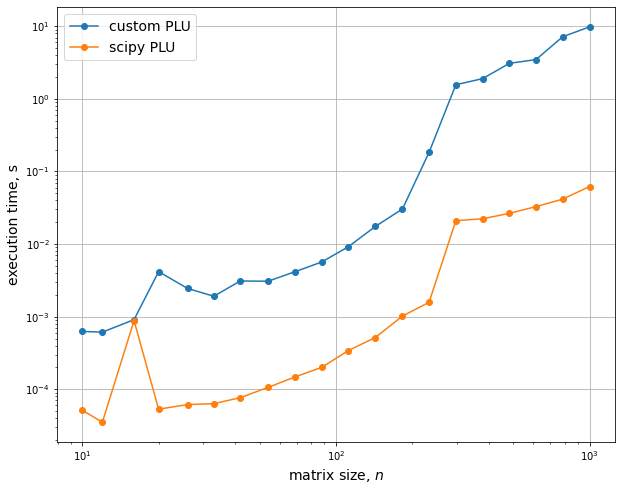

In [ ]:
plt.figure(figsize=(10, 8))

plt.plot(nn, execution_custom_plu, label='custom PLU', marker='o')
plt.plot(nn, execution_scipy_plu, label='scipy PLU', marker='o')
plt.xlabel('matrix size, $n$', fontsize=14)
plt.ylabel('execution time, s', fontsize=14)

plt.yscale('log')
plt.xscale('log')

plt.legend(fontsize=14)
plt.grid()
plt.show()

Scipy implementation is significantly faster probably because it employs linear algebra routine implemented in C or Fortran and 
has no python loops (which are quite slow)

### 4. Block LU (10 pts)

Let $A = \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix}$ be a block matrix. The goal is to solve the linear system

$$
     \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix} \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} = \begin{bmatrix} f_1 \\ f_2 \end{bmatrix}.
$$

* (2 pts) Using block elimination find matrix $S$ and right-hand side $\hat{f_2}$ so that $u_2$ can be found from $S u_2 = \hat{f_2}$. Note that the matrix $S$ is called <span style="color:red">Schur complement</span> of the block $A_{11}$.
* (4 pts) Using Schur complement properties prove that 

$$\det(X+AB) = \det(X)\det(I+BX^{-1}A), $$


where $X$ - nonsingular square matrix.
* (4 pts) Let matrix $F \in \mathbb{R}^{m \times n}$ and $G \in \mathbb{R}^{n \times m}$. Prove that 

$$\det(I_m - FG) = \det(I_n - GF).$$

4.1

Based on the given equation, we can write the following system

$$A_{11}u_1 + A_{12}u_2 = f_1$$
$$A_{21}u_1 + A_{22}u_2 = f_2$$

If matrix $A_{11}$ is invertable, we can left multiply the first equation by $A_{21}A_{11}^{-1}$

$$A_{21}A_{11}^{-1}(A_{11}u_1 + A_{12}u_2) = A_{21}A_{11}^{-1}f_1 \Longrightarrow 
A_{21}u_1 + A_{21}A_{11}^{-1}A_{12}u_2 = A_{21}A_{11}^{-1}f_1$$

and subtract it from the second one

$$A_{21}u_1 + A_{22}u_2 - A_{21}u_1 - A_{21}A_{11}^{-1}A_{12}u_2 = f_2 - A_{21}A_{11}^{-1}f_1$$
$$\Big[A_{22} - A_{21}A_{11}^{-1}A_{12}\Big]u_2 = f_2 - A_{21}A_{11}^{-1}f_1$$

Thus, the Schur complement $S$ and the right side $\hat{f_2}$ of the equation are the following
$$S = A_{22} - A_{21}A_{11}^{-1}A_{12},\;\hat{f_2} = f_2 - A_{21}A_{11}^{-1}f_1$$

4.2

Let us prove the following equations first

$$\det{D} \neq 0 \Longrightarrow \det{\begin{bmatrix} A & B \\ C & D \end{bmatrix}} = \det\Big[A-BD^{-1}C\Big]\cdot\det{D}$$
$$\det{A} \neq 0 \Longrightarrow \det{\begin{bmatrix} A & B \\ C & D \end{bmatrix}} = \det{A}\cdot\det\Big[D-CA^{-1}B\Big]$$

---

$$\begin{bmatrix} A & B \\ C & D \end{bmatrix}\begin{bmatrix} I & 0 \\ -D^{-1}C & I \end{bmatrix} = 
\begin{bmatrix} A-BD^{-1}C & B \\ 0 & D \end{bmatrix}$$

$$\det{\begin{bmatrix} A & B \\ C & D \end{bmatrix}\begin{bmatrix} I & 0 \\ -D^{-1}C & I \end{bmatrix}} = 
\det{\begin{bmatrix} A & B \\ C & D \end{bmatrix}}\det{\begin{bmatrix} I & 0 \\ -D^{-1}C & I \end{bmatrix}} =
\det{\begin{bmatrix} A-BD^{-1}C & B \\ 0 & D \end{bmatrix}}$$

$$\det{\begin{bmatrix} A & B \\ C & D \end{bmatrix}} = \det\Big[A-BD^{-1}C\Big]\cdot \det{D}$$

---

$$\begin{bmatrix} A & 0 \\ C & I \end{bmatrix}\begin{bmatrix} I & A^{-1}B \\ 0 & D-CA^{-1}B \end{bmatrix} = 
\begin{bmatrix} A & B \\ C & D \end{bmatrix}$$

$$\det{\begin{bmatrix} A & 0 \\ C & I \end{bmatrix}\begin{bmatrix} I & A^{-1}B \\ 0 & D-CA^{-1}B \end{bmatrix}} = 
\det{\begin{bmatrix} A & 0 \\ C & I \end{bmatrix}}\det{\begin{bmatrix} I & A^{-1}B \\ 0 & D-CA^{-1}B \end{bmatrix}} = 
\det{\begin{bmatrix} A & B \\ C & D \end{bmatrix}}$$

$$\det{\begin{bmatrix} A & B \\ C & D \end{bmatrix}} = \det{A}\cdot\det\Big[D - CA^{-1}B\Big]$$

---

Using the first equation, we can write

$$\det{\begin{bmatrix} I & B \\ -A & X \end{bmatrix}} = \det\Big[I + BX^{-1}A\Big]\cdot\det{X}$$

And using the second

$$\det{\begin{bmatrix} I & B \\ -A & X \end{bmatrix}} = \det\Big[X + AB\Big]$$

So we get
$$\det\Big[X + AB\Big] = \det{X}\cdot\det\Big[I + BX^{-1}A\Big]$$

4.3

We can again use the proven equations. In particular, the first one yields
$$\det{\begin{bmatrix} I_m & F \\ G & I_n \end{bmatrix}} = \det{I_n}\cdot\det\Big[I_m - FI_n^{-1}G\Big] = \det\Big[I_m - FG\Big]$$

And the second one
$$\det{\begin{bmatrix} I_m & F \\ G & I_n \end{bmatrix}} = \det{I_m}\cdot\det\Big[I_n - GI_m^{-1}F\Big] = \det\Big[I_n - GF\Big]$$

So we get
$$\det\Big[I_n - GF\Big] = \det\Big[I_m - FG\Big]$$

## Problem 2 (eigenvalues)  (50 pts)

### 1. Theoretical tasks (15 pts)

* (2 pts) Prove that eigenvectors that correspond to distinct eigenvalues are linearly independent.

* (3 pts) $A$ is a matrix such that $a_{i,j} \ge 0$ and $\sum_{j}a_{i,j} = 1$ (sum of the elements in each row is 1). Prove that $A$ has an eigenvalue $\lambda=1$ and that any eigenvalue $\lambda_i$: $|\lambda_i| \le 1$.

* (5 pts) Prove that normal matrix is Hermitian iff its eigenvalues are real. Prove that normal matrix is unitary iff its eigenvalues satisfy $|\lambda| = 1$. 

* (5 pts) The following problem illustrates instability of the Jordan form. Find theoretically the eigenvalues of the perturbed Jordan block (there is only one $\varepsilon$ - in the left lower corner):

$$
    J(\varepsilon) = 
    \begin{bmatrix} 
     \lambda & 1 & & & 0 \\ 
     0 & \lambda & 1 & & \\ 
     & 0 & \ddots & \ddots & \\ 
     & & 0 & \lambda & 1 \\ 
     \varepsilon & & & 0 & \lambda  \\ 
    \end{bmatrix}_{n\times n}
$$

   Comment how eigenvalues of $J(0)$ are perturbed for large $n$.

2.1.1

We can use induction by number $m$ of eigenvectors $v_k$ in linear combination. For the case of one eigenvector the statement is obvious. 
Suppose that it is also true for $m$ vectors
$$\sum\limits_{k = 1}^m \beta_k v_k = 0 \Longrightarrow \forall k \leqslant m: \beta_k = 0$$

Let us consider $m + 1$ eigenvector and apply $A$ to both sides of equation
$$A\sum\limits_{k = 1}^{m + 1} \alpha_k v_k = \sum\limits_{k = 1}^{m + 1} A\alpha_k v_k = \sum\limits_{k = 1}^{m + 1} \alpha_k \lambda_k v_k = 0$$

After that, subtract the original linear combination mutiplied by $\lambda_{m + 1}$
$$\sum\limits_{k = 1}^{m + 1} \alpha_k \lambda_k v_k - \sum\limits_{k = 1}^{m + 1} \alpha_k \lambda_{m + 1} v_k = 
\sum\limits_{k = 1}^m \big[\lambda_k - \lambda_{m + 1}\big]\alpha_k v_k = 0$$

Since $\lambda_k \neq \lambda_m$ when $k \neq m$, by the assumption of the induction we have
$$\forall k \leqslant m: \alpha_k = 0 \Longrightarrow \sum\limits_{k = 1}^{m + 1} \alpha_k v_k = \alpha_{m + 1} v_{m + 1} = 0,\;
\alpha_{m + 1} = 0$$

Thus, we get that $\forall k \leqslant m + 1: \alpha_k = 0$, which performs another step of induction and concludes the proof

2.1.2

Let us consider the action of matrix A on the vector $v$ of all ones and denote the result as $u$
$$\forall i: v_i = 1,\;u = Av \Longrightarrow u_i = \sum\limits_{j = 1}^n a_{ij}v_j = \sum\limits_{j = 1}^n a_{ij} = 1 = v_i$$

So we have $u = v$, which means that $v$ is the eigenvector of matrix $A$, and the corresponding eigenvalue is $1$.

---

Moreover, let us consider an arbitrary eigenvector $v$ of matrix $A$ with eigenvalue $\lambda$, and let us denote 
$i = \underset{j}{\text{argmax}}\,v_j$

$$|\lambda v_i| = \left|\sum\limits_{j = 1}^n a_{ij}v_j\right| \leqslant \sum\limits_{j = 1}^n a_{ij} \cdot |v_j| \leqslant 
\sum\limits_{j = 1}^n a_{ij} \cdot |v_i| = |v_i| \Longrightarrow |\lambda| \leqslant 1$$

The proof is concluded by the fact that it is true for every eigenvalue of matrix $A$

2.1.3

If normal matrix $A$ is Hermitian, then
$$A = U\Lambda U^*,\;A^* = (U\Lambda U^*)^* = U\Lambda^* U^* \Longrightarrow U\Lambda U^* = U\Lambda^* U^*,\;\Lambda = \Lambda^*$$

The last equation means that $\forall j: \lambda_j = \overline{\lambda_j}$, so $\lambda_j$ are real. 
The reverse statement can be proved likewise
$$A = U\Lambda U^*,\;\Lambda = \Lambda^* \Longrightarrow A^* = (U\Lambda U^*)^* = U\Lambda^* U^* = U\Lambda U^* = A$$

---

If normal matrix $A$ is unitary, then
$$A = U\Lambda U^*,\;A^* = (U\Lambda U^*)^* = U\Lambda^* U^*$$
$$I = AA^* = U\Lambda U^*U\Lambda^* U^* = U|\Lambda|^2 U^* \Longrightarrow I = U^*U = |\Lambda|^2 = |\Lambda|$$

The last equation means that $\forall j: |\lambda_j| = 1$. The reverse statement can be proved likewise
$$A = U\Lambda U^*,\;A^* = (U\Lambda U^*)^* = U\Lambda^* U^*$$
$$AA^* = U\Lambda U^*U\Lambda^* U^* = U|\Lambda|^2 U^* = U|\Lambda| U^* = UU^* = I,\;
A^*A = ... = U^*U = I$$

2.1.4

$$\det \big[J(\varepsilon) - \beta I\big] = (\lambda - \beta)\begin{vmatrix}
\lambda - \beta & 1 & 0 & \dots & 0 \\ 
0 & \lambda - \beta & 1 & \dots & 0 \\ 
0 & 0 & \lambda - \beta & \dots & 0 \\ 
\vdots & \vdots & \vdots & \ddots & \vdots \\ 
0 & 0 & 0 & \dots & \lambda - \beta
\end{vmatrix} - \begin{vmatrix}
0 & 1 & 0 & \dots & 0 \\ 
0 & \lambda - \beta & 1 & \dots & 0 \\ 
0 & 0 & \lambda - \beta & \dots & 0 \\ 
\vdots & \vdots & \vdots & \ddots & \vdots \\ 
\varepsilon & 0 & 0 & \dots & \lambda - \beta
\end{vmatrix} =$$
$$= (\lambda - \beta)^n - (-1)^n\varepsilon = 0 \Longrightarrow (\lambda - \beta)^n = (-1)^n\varepsilon,\;
(\beta - \lambda)^n = \varepsilon,\;\beta_n = \lambda + (\pm 1)^{n + 1} \varepsilon^{1/n}$$

$$\lim_{n \to \infty}\inf\beta_n = \lambda - 1,\;\lim_{n \to \infty}\sup\beta_n = \lambda + 1$$

It can be seen that for large $n$ the eigenvalues $\beta_n$ are shifted by $+1$ or $-1$ from $\lambda$

### 2. PageRank (35 pts)


#### Damping factor importance

* (5 pts) Write the function ```pagerank_matrix(G)``` that takes an adjacency matrix $G$ (in both sparse and dense formats) as an input and outputs the corresponding PageRank matrix $A$.

In [ ]:
# INPUT:  G - np.ndarray or sparse matrix
# OUTPUT: A - np.ndarray (of size G.shape) or sparse matrix

def pagerank_matrix(G):
    if isinstance(G, np.ndarray):
        # consider G matrix as standard adjacency matrix — g[i, j] = 1 iff there is an edge from i to j
        # matrix P is constructed in another way — p[i, j] = 1 iff there is an edge from j to i
        P = G.T

        # count out degree of every node by summing up the corresponding column
        out_degrees = P.sum(axis=0)

        # deal with zero values
        out_degrees[out_degrees == 0] = 1

        # normalize matrix P in order to obtain left stochastic matrix of transitio
        return P @ np.diag(1 / out_degrees)
    
    elif isinstance(G, sp.sparse.csr_matrix):
        P = G.T
        out_degrees = P.sum(axis=0).A1
        out_degrees[out_degrees == 0] = 1

        return P @ sp.sparse.diags(1 / out_degrees)
        
    else:
        raise NotImplementedError()

* (3 pts) Find PageRank matrix $A$ that corresponds to the following graph.
What is its largest eigenvalue? What multiplicity does it have?

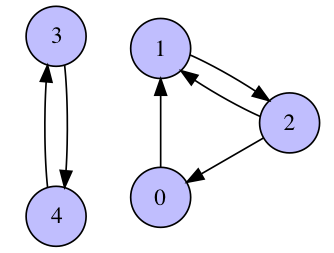

In [ ]:
from IPython.display import Image
Image(filename='graph.png', width=300)

In [ ]:
G = np.array([[0, 1, 0, 0, 0],
              [0, 0, 1, 0, 0],
              [1, 1, 0, 0, 0],
              [0, 0, 0, 0, 1],
              [0, 0, 0, 1, 0]])

# G = sp.sparse.csr_matrix(G)
A = pagerank_matrix(G)

In [ ]:
A

array([[0. , 0. , 0.5, 0. , 0. ],
       [1. , 0. , 0.5, 0. , 0. ],
       [0. , 1. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 1. ],
       [0. , 0. , 0. , 1. , 0. ]])

The largest eigenvalue is $1$ with multiplicity $2$

In [ ]:
np.linalg.eigvals(A)

array([-0.5+0.5j, -0.5-0.5j,  1. +0.j ,  1. +0.j , -1. +0.j ])

* (5 pts) Implement the power method for a given matrix $A$, an initial guess $x_0$ and a number of iterations ```num_iter```. It should be organized as a function ```power_method(A, x0, num_iter)``` that outputs approximation to eigenvector $x$, eigenvalue $\lambda$ and history of residuals $\{\|Ax_k - \lambda_k x_k\|_2\}$. Make sure that the method converges to the correct solution on a matrix $\begin{bmatrix} 2 & -1 \\ -1 & 2 \end{bmatrix}$ which is known to have the largest eigenvalue equal to $3$.

In [ ]:
# INPUT:  A - np.ndarray (2D), x0 - np.ndarray (1D), num_iter - integer (positive)
# OUTPUT: x - np.ndarray (of size x0), l - float, res - np.ndarray (of size num_iter + 1 [include initial guess])

def power_method(A, x0, num_iter):
    x = x0.copy() / np.linalg.norm(x0)
    history = []
    
    for i in range(num_iter):
        x_map = A @ x
        eigenvalue = np.dot(x_map, x)

        history.append(np.linalg.norm(x_map - eigenvalue * x))
        x = x_map / np.linalg.norm(x_map)
    
    x_map = A @ x
    eigenvalue = np.dot(x_map, x)

    history.append(np.linalg.norm(x_map - eigenvalue * x))
    return x, eigenvalue, history

In [ ]:
B = np.array([[2, -1],
              [-1, 2]])

eigenvector_approx, eigenvalue_approx, history = power_method(B, np.random.randn(2), 100)
print(f'the approximate largest eigenvalue is {eigenvalue_approx:.4f}, while the true one is 3')

the approximate largest eigenvalue is 3.0000, while the true one is 3


* (2 pts) Run the power method for the graph presented above and plot residuals $\|Ax_k - \lambda_k x_k\|_2$ as a function of $k$ for ```num_iter=100``` and random initial guess ```x0```.  Explain the absence of convergence. 

In [ ]:
eigenvector_approx, eigenvalue_approx, history = power_method(A, np.random.randn(A.shape[1]), 100)

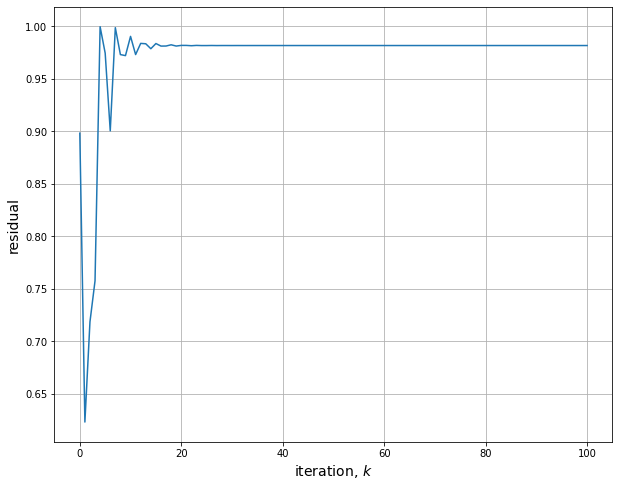

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(range(len(history)), history)

plt.xlabel('iteration, $k$', fontsize=14)
plt.ylabel('residual', fontsize=14)

plt.grid()
plt.show()

In [ ]:
np.linalg.eigvals(A)

array([-0.5+0.5j, -0.5-0.5j,  1. +0.j ,  1. +0.j , -1. +0.j ])

Since there is no dominant eigenvalue — that is, $|\lambda_2 / \lambda_1| = 1$ because is $A$ has eigenvalues $1$ and $-1$ with equal module, 
the convergence is not guaranteed

* (2 pts) Consider the same graph, but with additional self loop at node 4 (self loop is an edge that connects a vertex with itself). Plot residuals as in the previous task and discuss the convergence. Now, run the power method with ```num_iter=100``` for 10 different initial guesses and print/plot the resulting approximated eigenvectors. Why do they depend on the initial guess?

In [ ]:
G_self_looped = G.copy()
G_self_looped[4, 4] = 1
A_self_looped = pagerank_matrix(G_self_looped)

In [ ]:
eigenvector_approx, eigenvalue_approx, history = power_method(A_self_looped, np.random.randn(A.shape[1]), 100)

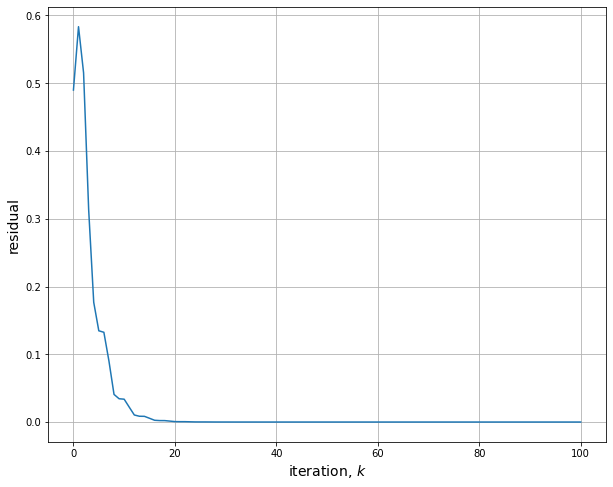

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(range(len(history)), history)

plt.xlabel('iteration, $k$', fontsize=14)
plt.ylabel('residual', fontsize=14)

plt.grid()
plt.show()

In [ ]:
n_runs = 10
eigenvector_per_run = []

for i in range(n_runs):
    eigenvector_approx, eigenvalue_approx, history = power_method(A_self_looped, np.random.randn(A.shape[1]), 100)
    eigenvector_per_run.append(eigenvector_approx)

In [ ]:
eigenvector_per_run = np.array(eigenvector_per_run)
np.sort(np.abs(eigenvector_per_run), axis=0)

array([[0.0021773 , 0.00435461, 0.00435461, 0.11649361, 0.23298721],
       [0.04750546, 0.09501092, 0.09501092, 0.16122805, 0.3224561 ],
       [0.18998466, 0.37996932, 0.37996932, 0.25664582, 0.51329164],
       [0.20136621, 0.40273242, 0.40273242, 0.30333568, 0.60667136],
       [0.21728497, 0.43456994, 0.43456994, 0.32741918, 0.65483835],
       [0.22705443, 0.45410885, 0.45410885, 0.33914161, 0.67828323],
       [0.24493476, 0.48986952, 0.48986952, 0.35638879, 0.71277758],
       [0.27298038, 0.54596077, 0.54596077, 0.36746496, 0.73492991],
       [0.31091756, 0.62183513, 0.62183513, 0.44264864, 0.88529727],
       [0.32182573, 0.64365146, 0.64365146, 0.44720406, 0.89440811]])

In [ ]:
np.linalg.eigvals(A_self_looped)

array([-0.5+0.5j, -0.5-0.5j,  1. +0.j , -0.5+0.j ,  1. +0.j ])

Matrix $A$ doen't have eigenvalue $-1$, so the convergence is now guaranteed. However, the eigenvalue $1$ has multiplicity $2$, 
and since $A$ is diagonalizable (in particular, algebraic and geometric multiplicities are equal for any eigenvalue), there are two 
eigenvectors corresponding to this eigenvalue, so the iteration process converges to some random linear combination in the subspace spanned by these vectors 
(as I understand, it depends on the initial vector $x_0$)

In order to avoid this problem Larry Page and Sergey Brin [proposed](http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf) to use the following regularization technique:

$$
A_d = dA + \frac{1-d}{N} \begin{bmatrix} 1 & \dots & 1 \\ \vdots & & \vdots \\ 1 & \dots & 1 \end{bmatrix},
$$

where $d$ is a small parameter in $[0,1]$ (typically $d=0.85$), which is called **damping factor**, $A$ is of size $N\times N$. Now $A_d$ is the matrix with multiplicity of the largest eigenvalue equal to 1. 
Recall that computing the eigenvector of the PageRank matrix, which corresponds to the largest eigenvalue, has the following interpretation. Consider a person who stays in a random node of a graph (i.e. opens a random web page); at each step s/he follows one of the outcoming edges uniformly at random (i.e. opens one of the links). So the person randomly walks through the graph and the eigenvector we are looking for is exactly his/her stationary distribution for each node it tells you the probability of visiting this particular node. Therefore, if the person has started from a part of the graph which is not connected with the other part, he will never get there.  In the regularized model, the person at each step follows one of the outcoming links with probability $d$ OR teleports to a random node from the whole graph with probability $(1-d)$.

* (2 pts) Now, run the power method with $A_d$ and plot residuals $\|A_d x_k - \lambda_k x_k\|_2$ as a function of $k$ for $d=0.97$, ```num_iter=100``` and a random initial guess ```x0```.

In [ ]:
def power_method_damping(A, x0, num_iter, d):
    A = d * A.copy() + (1 - d) / A.shape[0] * np.ones_like(A)
    
    return power_method(A, x0, num_iter)

In [ ]:
eigenvector_approx, eigenvalue_approx, history = power_method(A_self_looped, np.random.randn(A.shape[1]), 100)

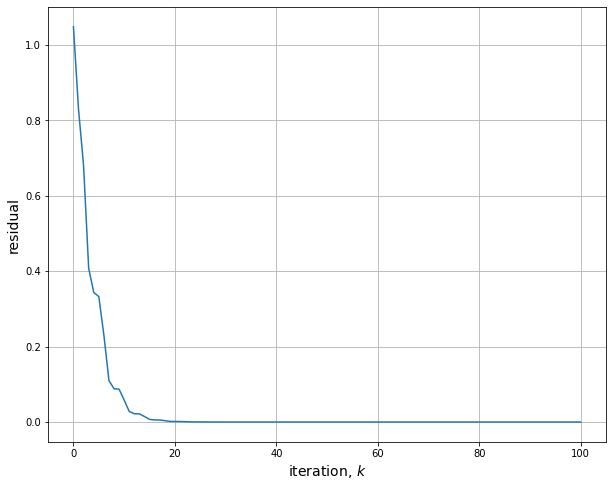

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(range(len(history)), history)

plt.xlabel('iteration, $k$', fontsize=14)
plt.ylabel('residual', fontsize=14)

plt.grid()
plt.show()

* (5 pts) Find the second largest in the absolute value eigenvalue of the obtained matrix $A_d$. How and why is it connected to the damping factor $d$? What is the convergence rate of the PageRank algorithm when using damping factor?

In [ ]:
d = 0.97
A_damping = d * A_self_looped.copy() + (1 - d) / A.shape[0] * np.ones_like(A)
np.linalg.eigvals(A_damping)

array([-0.485+0.485j, -0.485-0.485j,  1.   +0.j   ,  0.97 +0.j   ,
       -0.485+0.j   ])

The second largest eigenvalue of matrix $A_d$ is $d = 0.97$, and the convergence rate is $|\lambda_2 / \lambda_1| = d$

Usually, graphs that arise in various areas are sparse (social, web, road networks, etc.) and, thus, computation of a matrix-vector product for corresponding PageRank matrix $A$ is much cheaper than $\mathcal{O}(N^2)$. However, if $A_d$ is calculated directly, it becomes dense and, therefore, $\mathcal{O}(N^2)$ cost grows prohibitively large for  big $N$.


* (2 pts) Implement fast matrix-vector product for $A_d$ as a function ```pagerank_matvec(A, d, x)```, which takes a PageRank matrix $A$ (in sparse format, e.g., ```csr_matrix```), damping factor $d$ and a vector $x$ as an input and returns $A_dx$ as an output. 

* (1 pts) Generate a random adjacency matrix of size $10000 \times 10000$ with only 100 non-zero elements and compare ```pagerank_matvec``` performance with direct evaluation of $A_dx$.

In [ ]:
# INPUT:  A - np.ndarray (2D), d - float (from 0.0 to 1.0), x - np.ndarray (1D, size of A.shape[0/1])
# OUTPUT: y - np.ndarray (1D, size of x)

def pagerank_matvec_sparse(A, d, x):
    return d * A @ x + ((1 - d) / A.shape[0] * x.sum()) * np.ones_like(x)

def pagerank_matvec_dense(A, d, x):
    return (d * A + (1 - d) / A.shape[0] * np.ones_like(A)) @ x

In [ ]:
d = 0.97
A = sp.sparse.random(10000, 10000, 100 / (10000 * 10000))
x = np.random.randn(10000)

In [ ]:
A_dense = A.todense()

In [ ]:
time_sparse = timeit.timeit(lambda: pagerank_matvec_sparse(A, d, x), number=10) / 10

In [ ]:
time_dense = timeit.timeit(lambda: pagerank_matvec_dense(A_dense, d, x), number=10) / 10

In [ ]:
time_dense / time_sparse

16041.936054671356

Sparse implementation is thousands times faster

#### DBLP: computer science bibliography

Download the dataset from [here](https://goo.gl/oZVxEa), unzip it and put `dblp_authors.npz`  and `dblp_graph.npz` in the same folder with this notebook. Each value (author name) from `dblp_authors.npz` corresponds to the row/column of the matrix from `dblp_graph.npz`. Value at row `i` and column `j` of the matrix from `dblp_graph.npz` corresponds to the number of times author `i` cited papers of the author `j`. Let us now find the most significant scientists according to PageRank model over DBLP data.

* (4 pts) Load the weighted adjacency matrix and the authors list into Python using ```load_dblp(...)``` function. Print its density (fraction of nonzero elements). Find top-10 most cited authors from the weighted adjacency matrix. Now, make all the weights of the adjacency matrix equal to 1 for simplicity (consider only existence of connection between authors, not its weight). Obtain the PageRank matrix $A$ from the adjacency matrix and verify that it is stochastic.

In [ ]:
from scipy.sparse import load_npz

In [ ]:
def load_dblp(path_auth, path_graph):
    G = load_npz(path_graph).astype(float)

    with np.load(path_auth) as data: 
        authors = data['authors']
        
    return G, authors

In [ ]:
G, authors = load_dblp('dblp_authors.npz', 'dblp_graph.npz')

In [ ]:
print(f'matrix density: {G.getnnz() / (G.shape[0] * G.shape[1]):.6f}')

matrix density: 0.000045


In [ ]:
top_author_indices, top = G.sum(axis=0).argsort().A1, 10

In [ ]:
print(f'top {top} most cited authors\n{authors[top_author_indices[-top:][::-1]]}')

top 10 most cited authors
['Scott Shenker' 'Andrew Zisserman' 'Hari Balakrishnan' 'Jiawei Han'
 'Anil K. Jain' 'Cordelia Schmid' 'Jitendra Malik' 'Ion Stoica'
 'David E. Culler' 'David G. Lowe']


In [ ]:
G.data[:] = 1
G_sparse = sp.sparse.csr_matrix(G)

In [ ]:
A = pagerank_matrix(G_sparse)

In [ ]:
A.sum(axis=0).max(), A.sum(axis=0).min()

(1.0000000000000004, 0.0)

Matrix $A$ is almost stochastic — there are zero columns just because it contains nodes which do not have any out edges, 
but damping factor helps to deal with it

* (1 pts) In order to provide ```pagerank_matvec``` to your ```power_method``` (without rewriting it) for fast calculation of $A_dx$, you can create a ```LinearOperator```: 
```python
L = scipy.sparse.linalg.LinearOperator(A.shape, matvec=lambda x, A=A, d=d: pagerank_matvec(A, d, x))
```
Calling ```L@x``` or ```L.dot(x)``` will result in calculation of ```pagerank_matvec(A, d, x)``` and, thus, you can plug $L$ instead of the matrix $A$ in the ```power_method``` directly. **Note:** though in the previous subtask graph was very small (so you could disparage fast matvec implementation), here it is very large (but sparse), so that direct evaluation of $A_dx$ will require $\sim 10^{12}$ matrix elements to store - good luck with that (^_<).

In [ ]:
from scipy.sparse.linalg import LinearOperator

In [ ]:
d = 0.85

In [ ]:
L = LinearOperator(A.shape, matvec=lambda x, A=A, d=d: pagerank_matvec_sparse(A, d, x))

* (2 pts) Run the power method starting from the vector of all ones and plot residuals $\|A_dx_k - \lambda_k x_k\|_2$  as a function of $k$ for $d=0.85$.

In [ ]:
%%time
eigenvector_approx, eigenvalue_approx, history = power_method(L, np.ones(A.shape[1]), 100)

CPU times: user 2min 23s, sys: 11.7 s, total: 2min 35s
Wall time: 2min 22s


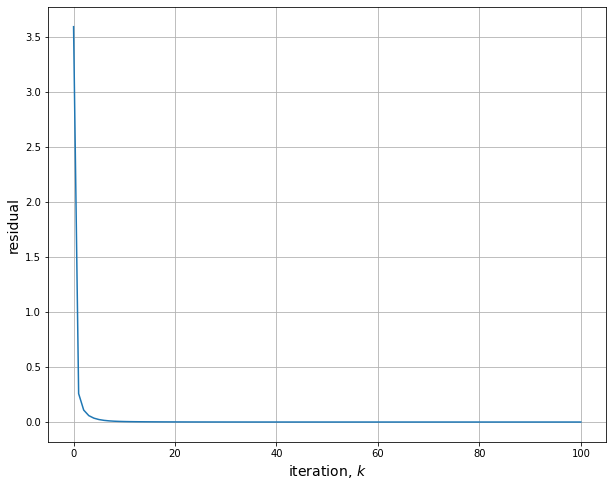

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(range(len(history)), history)

plt.xlabel('iteration, $k$', fontsize=14)
plt.ylabel('residual', fontsize=14)

plt.grid()
plt.show()

* (1 pts) Print names of the top-10 authors according to PageRank over DBLP when $d=0.85$. Comment on your findings.

In [ ]:
top_author_indices, top = eigenvector_approx.argsort(), 10

In [ ]:
print(f'top {top} important authors according to PageRank\n{authors[top_author_indices[-top:][::-1]]}')

top 10 important authors according to PageRank
['David E. Goldberg' 'Richard M. Karp' 'John E. Hopcroft'
 'Azriel Rosenfeld' 'Ronald L. Rivest' 'Anil K. Jain' 'Takeo Kanade'
 'Alfred V. Aho' 'Robert Endre Tarjan' 'Gerard Salton']


## Problem 3. QR algorithm (33 pts)

* Implement QR-algorithm without shifts. Prototype of the function is given below

The pure QR algorithm can be described as
$$A_1 = A,\;Q_kR_k = A_k \Longrightarrow A_{k + 1} = R_kQ_k$$
$$R_k = Q_k^*A_k,\;\widetilde{Q}_k = \prod_{i = 1}^k Q_i,\;\widetilde{R}_k = \prod_{i = k}^1 R_i 
\Longrightarrow A_{k + 1} = R_kQ_k = Q_k^*A_kQ_k = \widetilde{Q}_k^*A\widetilde{Q}_k$$

Here we obtain the approximation of eigenvalues in power method manner
$$Q_{k + 1}R_{k + 1} = \widetilde{Q}_k^*A\widetilde{Q}_k \Longrightarrow
\widetilde{Q}_{k + 1}R_{k + 1} = A\widetilde{Q}_k,\;A^k = \prod_{i = 1}^k A_1 = \prod_{i = 1}^k Q_1R_1 = 
Q_1\left[\prod_{i = 1}^k A_2\right]R_1 = \dots = \widetilde{Q}_k\widetilde{R}_k$$

In [ ]:
# INPUT: A_init - square matrix, 
#        num_iter - number of iterations for QR algorithm

# OUTPUT: Ak - transformed matrix A_init given by QR algorithm, 
#         convergence - numpy array of shape (num_iter, ), 
#         where we store the maximal number from the Chebyshev norm 
#         of triangular part of the Ak for every iteration

def qr_algorithm(A_init, num_iter):
    A = A_init.copy()
    history = []

    for i in range(num_iter):
        Q, R = np.linalg.qr(A)
        A = R @ Q
        triangular_norm = np.max(np.abs(np.tril(A) - np.diag(np.diag(A))))
        history.append(triangular_norm)

    return A, history

#### Symmetric case (3 pts)
- Create symmetric tridiagonal $11 \times 11$ matrix with elements $-1, 2, -1$ on sub-, main- and upper diagonal respectively without using loops.
- Run $400$ iterations of the QR algorithm for this matrix.
- Plot the output matrix with function ```plt.spy(Ak, precision=1e-7)```.
- Plot convergence of QR-algorithm.

In [ ]:
size = 11
A = np.diag([2] * size) + np.diag([-1] * (size - 1), -1) + np.diag([-1] * (size - 1), 1)

In [ ]:
np.sort(np.abs(np.linalg.eig(A)[0]))

array([0.06814835, 0.26794919, 0.58578644, 1.        , 1.48236191,
       2.        , 2.51763809, 3.        , 3.41421356, 3.73205081,
       3.93185165])

In [ ]:
A, history_pure_symmetric = qr_algorithm(A, 400)

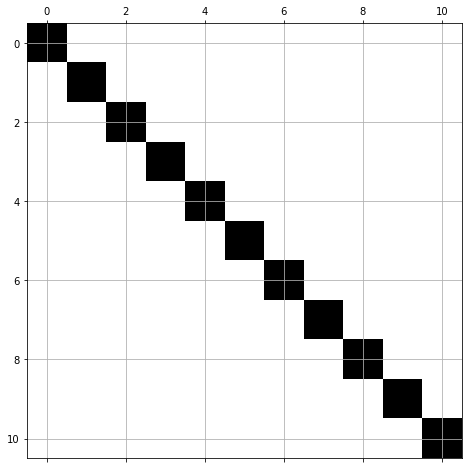

In [ ]:
plt.figure(figsize=(8, 8))
plt.spy(A, precision=1e-7)
plt.grid()
plt.show()

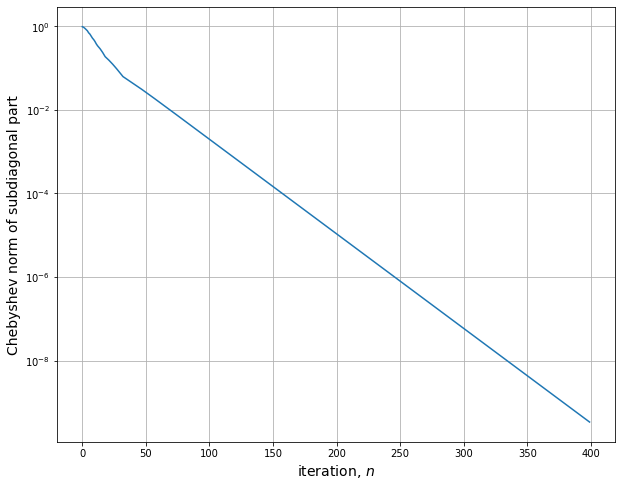

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(history_pure_symmetric)

plt.xlabel('iteration, $n$', fontsize=14)
plt.ylabel('Chebyshev norm of subdiagonal part', fontsize=14)

plt.yscale('log')
plt.grid()
plt.show()

#### Nonsymmetric case (5 pts)

- Create nonsymmetric tridiagonal $11 \times 11$ matrix with elements $5, 3, -2$ on sub-, main- and upper diagonal respectively without using loops.
- Run $250$ iterations of the QR algorithm for this matrix.
- Plot the result matrix with function ```plt.spy(Ak, precision=1e-7)```. Is this matrix lower triangular? How does this correspond to the claim about convergence of the QR algorithm?

In [ ]:
size = 11
A = np.diag([3] * size) + np.diag([5] * (size - 1), -1) + np.diag([-2] * (size - 1), 1)

In [ ]:
np.sort(np.abs(np.linalg.eig(A)[0]))

array([3.        , 3.41752717, 3.41752717, 4.35889894, 4.35889894,
       5.38516481, 5.38516481, 6.244998  , 6.244998  , 6.80591714,
       6.80591714])

In [ ]:
A, history_pure_non_symmetric = qr_algorithm(A, 250)

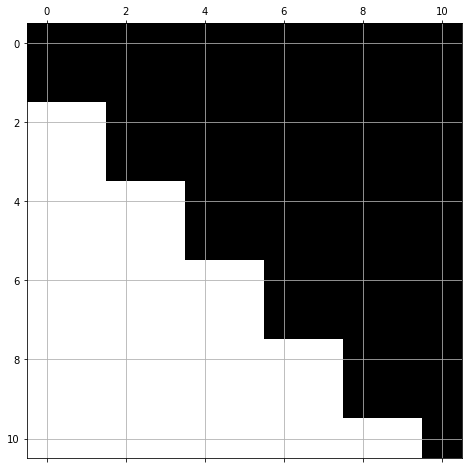

In [ ]:
plt.figure(figsize=(8, 8))
plt.spy(A, precision=1e-7)
plt.grid()
plt.show()

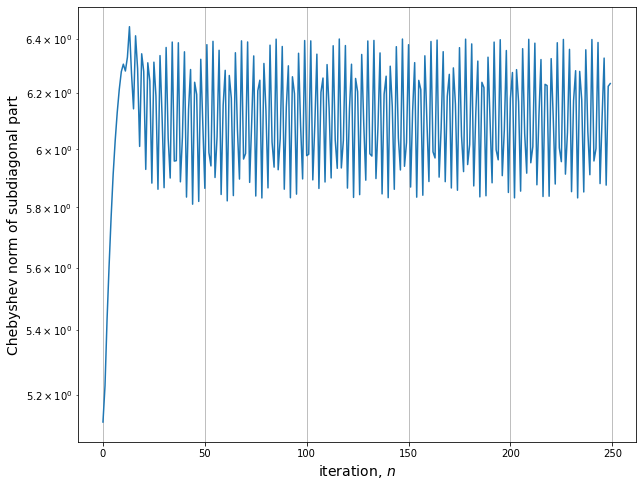

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(history_pure_non_symmetric)

plt.xlabel('iteration, $n$', fontsize=14)
plt.ylabel('Chebyshev norm of subdiagonal part', fontsize=14)

plt.yscale('log')
plt.grid()
plt.show()

As can be seen, the matrix is not upper triangular. Taking into account the relation between QR algorithm and power method, the absence of convergence here can be explained by the fact that $\lambda_1 = \lambda_2$  — consequently, the second leading submatrix of $A_n$ describes some $2$-dimensional subspace. As it was discussed in the section about power method, it violates the condition of convergence 
$|\lambda_2 / \lambda_1| < 1$

In [ ]:
A[:2, :2]

array([[ 3.25699246, -5.99656164],
       [ 6.23466503,  2.74300754]])

### QR algorithms with Rayleigh Quotient shift (10 pts)

In the lectures the Rayleigh Quotient shift was introduced to speed up convergence of power method. Here we ask you to generalize this approach to construct the shifts in QR algorithm.

- How to compute the Rayleigh Quotient shift in QR algorithm fast? Provide formulas and explanations how they can be simplified.
- Implement explicit QR algorithm with Rayleigh Quotient shift. Please do not worry about implicit orthogonalization, we want to compare convergence only in terms of iterations.
- Test your implementation in the symmetric case. Plot the convergence of QR algorithm with and without shift. Choose the dimension $n \sim 100 $ for more representative results. 
- How the convergence of the shifted algorithm compares to the simple QR? Why? 

The QR algorithm with shifts can be described as
$$A_1 = A,\;Q_kR_k = A_k - \mu_k I \Longrightarrow A_{k + 1} = R_kQ_k + \mu_k I$$
$$R_k = Q_k^*\Big[A_k - \mu_k I\Big],\;\widetilde{Q}_k = \prod_{i = 1}^k Q_i,\;\widetilde{R}_k = \prod_{i = k}^1 R_i 
\Longrightarrow A_{k + 1} = R_kQ_k + \mu_k I =$$
$$= Q_k^*\Big[A_k - \mu_k I\Big]Q_k + \mu_k I = 
Q_k^*A_kQ_k - \mu_k Q_k^*Q_k + \mu_k I = Q_k^*A_kQ_k = \widetilde{Q}_k^*A\widetilde{Q}_k$$

The Rayleigh quotient shift is defined as
$$\mu_k = \frac{(q_k^n)^*Aq_k^n}{(q_k^n)^*q_k^n} = (q_k^n)^*Aq_k^n$$

Here $q_k^n$ represents the $n$'th column of matrix $\widetilde{Q}_k$. The expression can be simplified in such way
$$\mu_k = (q_k^n)^*Aq_k^n = (e^n)^T\widetilde{Q}_k^*A\widetilde{Q}_ke^n = (e^n)^T A_{k + 1}e^n = \big[A_{k + 1}\big]_{nn}$$

In [ ]:
def qr_algorithm_rayleigh(A_init, num_iter):
    A = A_init.copy()
    history = []

    for i in range(num_iter):
        mu_rayleigh = A[-1, -1]
        Q, R = np.linalg.qr(A - mu_rayleigh * np.identity(len(A)), mode='complete')
        A = R @ Q + mu_rayleigh * np.identity(len(A))

        significant_lower_triangular = np.tril(A, -1) * (np.abs(np.tril(A, -1)) > 1e-8)
        significant_upper_triangular = np.triu(A, 1) * (np.abs(np.triu(A, 1)) > 1e-8)
        A = np.diag(np.diag(A)) + significant_lower_triangular + significant_upper_triangular

        triangular_norm = np.max(np.abs(np.tril(A, -1)))
        history.append(triangular_norm)

    return A, history

In [ ]:
size = 100
A_init = np.diag([2] * size) + np.diag([-1] * (size - 1), -1) + np.diag([-1] * (size - 1), 1)

In [ ]:
A, history_pure_symmetric = qr_algorithm(A_init, int(1e3))

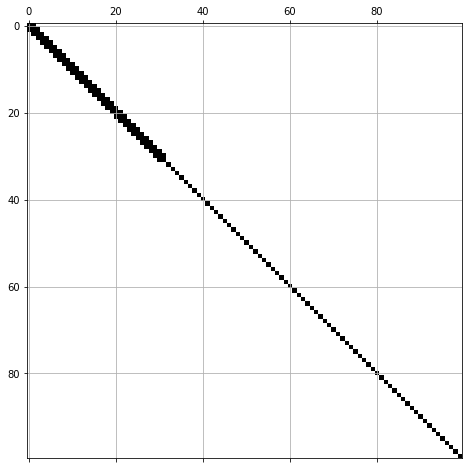

In [ ]:
plt.figure(figsize=(8, 8))
plt.spy(A, precision=1e-7)
plt.grid()
plt.show()

In [ ]:
A, history_rayleigh_symmetric = qr_algorithm_rayleigh(A_init, int(1e3))

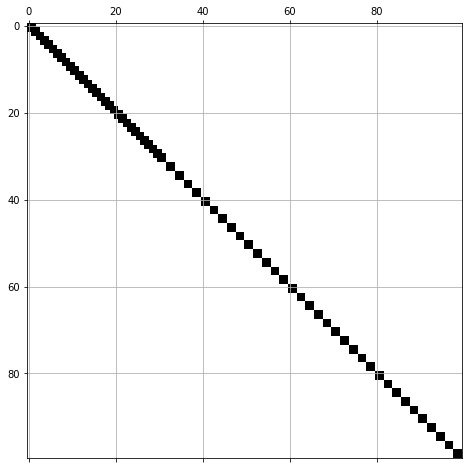

In [ ]:
plt.figure(figsize=(8, 8))
plt.spy(A, precision=1e-7)
plt.grid()
plt.show()

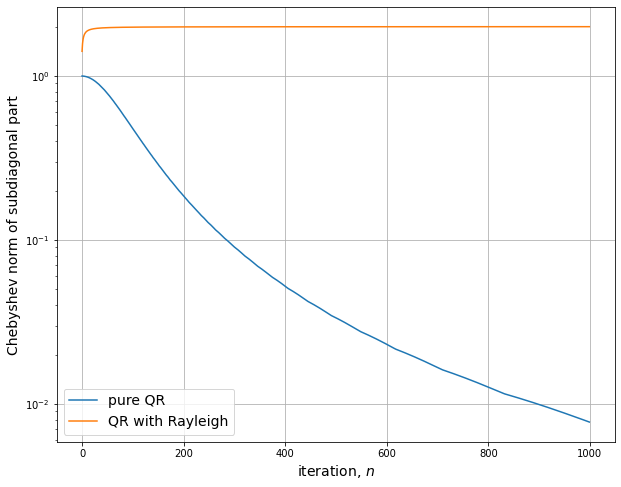

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(history_pure_symmetric, label='pure QR')
plt.plot(history_rayleigh_symmetric, label='QR with Rayleigh')

plt.xlabel('iteration, $n$', fontsize=14)
plt.ylabel('Chebyshev norm of subdiagonal part', fontsize=14)

plt.yscale('log')
plt.legend(fontsize=14)
plt.grid()
plt.show()

It was expected that the QR algorithm with Rayleigh quotient is faster, but I somehow couldn't manage to implement it...
<!-- We can see that the convergence in case of Rayleigh quotient is much faster -->

- Try QR with Rayleigh Quotient shift for a simple matrix $A = \begin{bmatrix}
0 & 1 \\
1 & 0
\end{bmatrix}$. Does anything change from iteration to iteration? Does shift affect convergence here? Why?

In [ ]:
A_init = np.array([[0, 1], [1, 0]])

In [ ]:
A, history_rayleigh_simple = qr_algorithm_rayleigh(A_init, 400)

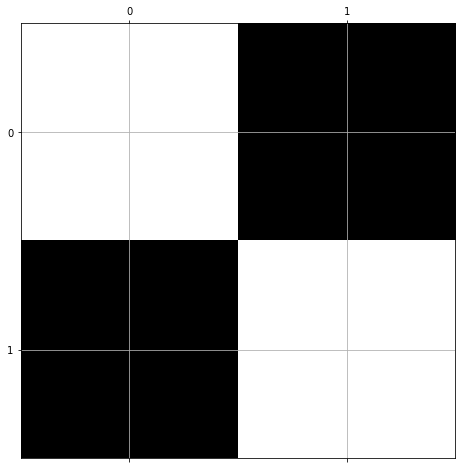

In [ ]:
plt.figure(figsize=(8, 8))
plt.spy(A, precision=1e-7)
plt.grid()
plt.show()

In [ ]:
np.where(np.array(history_rayleigh_simple) != 1)[0]

array([], dtype=int64)

It's obvious that nothing changes, so let us check why

In [ ]:
A

array([[0., 1.],
       [1., 0.]])

In [ ]:
q, r = np.linalg.qr(A)

In [ ]:
r @ q

array([[0., 1.],
       [1., 0.]])

Since every Rayleigh quotient $\mu_k$ equals to $0$, shifted QR is the same as pure QR algorithm, so the $Q_k$ and $R_k$ factors are 
also the same at every iteration which makes the algorithm stuck

### QR with Wilkinson shift  (15 pts)

To solve the problem that appears in the last example, we can use the Wilkinson shift:

$$\mu = a_m - \frac {sign(\delta) b^2_{m-1}} {(|\delta| + \sqrt{\delta^2 + b^2_{m-1}} )},$$

where $\delta = \frac{(a_{m-1} - a_m)}{2}$. If $\delta = 0$, then instead of $sign(\delta)$ you have to choose $1$ or $-1$ arbitrary.
The numbers $a_m, b_{m-1}, a_{m-1}$ are taken from matrix $B$:

$$
    B = 
    \begin{bmatrix} 
     a_{m-1} & b_{m-1} \\ 
     b_{m-1} & a_m \\ 
    \end{bmatrix},
$$  
which is a lower right bottom submatrix of $A^{(k)}$. Here $k$ is an iteration counter in QR algorithm.

- Compare convergence in the symmetric cases: 
    - distinctive eigenvalues
    - two coincident eigenvalues
    - maximum and minimum eigenvalues with the same absolute value
Choose the dimension $n \sim 100 $ for more representative results.
What do you observe? 

In [ ]:
def calculate_wilkinson_shift(A):
    B = A[-2:, -2:]
    delta = (B[0, 0] - B[1, 1]) / 2
    mu_wilkinson = B[1, 1] - (int(delta == 0) + np.sign(delta)) * B[0, 1] ** 2 / (np.abs(delta) + np.sqrt(delta ** 2 + B[0, 1] ** 2))
    return mu_wilkinson

def qr_algorithm_wilkinson(A_init, num_iter):
    A = A_init.copy()
    history = []

    for i in range(num_iter):
        mu_wilkinson = calculate_wilkinson_shift(A)
        Q, R = np.linalg.qr(A - mu_wilkinson * np.identity(len(A)))
        A = R @ Q + mu_wilkinson * np.identity(len(A))

        triangular_norm = np.max(np.abs(np.tril(A) - np.diag(np.diag(A))))
        history.append(triangular_norm)

    return A, history

In [ ]:
size = 100
A_init = np.diag([2] * size) + np.diag([-1] * (size - 1), -1) + np.diag([-1] * (size - 1), 1)

In [ ]:
_, history_pure_distinctive = qr_algorithm(A_init, int(1e3))

In [ ]:
_, history_rayleigh_distinctive = qr_algorithm_rayleigh(A_init, int(1e3))

In [ ]:
_, history_wilkinson_distinctive = qr_algorithm_wilkinson(A_init, int(1e3))

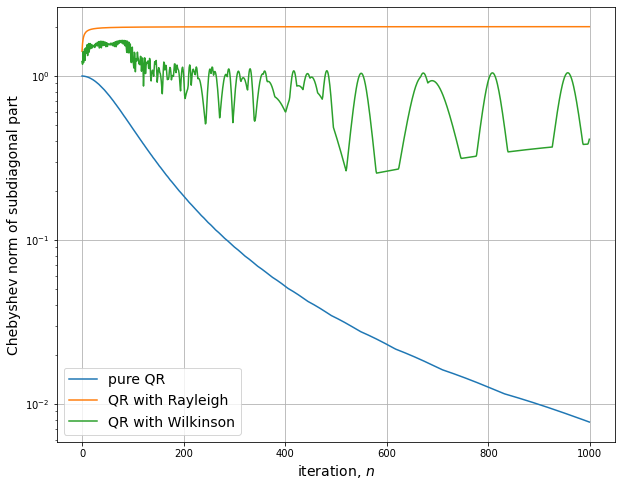

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(history_pure_distinctive, label='pure QR')
plt.plot(history_rayleigh_distinctive, label='QR with Rayleigh')
plt.plot(history_wilkinson_distinctive, label='QR with Wilkinson')

plt.xlabel('iteration, $n$', fontsize=14)
plt.ylabel('Chebyshev norm of subdiagonal part', fontsize=14)

plt.yscale('log')
plt.legend(fontsize=14)
plt.grid()
plt.show()

And the same with Wilkinson, my bad

## Problem 4. (Movie Recommender system) 15 pts

Imagine the world without NLA where you have free evenings and you can watch movies!  
But it is always hard to choose a movie to watch. 
In this problem we suggest you to build your own movie recommender system based on SVD decomposition, so you can combine two perfect things: Numerical Linear Algebra and cinematography!

In order to build recommender system you need data. 
Here you are https://grouplens.org/datasets/movielens/1m/

Usually all recommender systems may be devided into two groups

#### Collaborative filtering. 

This approach is based on user-item interaction.
It has one important assumption: user who has liked an item in the past will also likes the same in the future. Suppose the user A likes the films about vampires. 
He is Twilight saga fan and he has watched the film "What we do in the shadows" and liked it or unliked it, in other words he evaluated it somehow. And suppose another user B, who has the similair behavior to the first user (he is also Twilight saga fan). And the chance, that he will estimate "What we do in the shadows" in the same way that user A did, is huge. So, the purpose of the collaborative filtering is to predict a user's behavior based on behavior of the simular users.

#### Content based filtering.

Collaborative filtering has some essential flaws. The main one is called "cold start". "Cold start" happens when the new user comes and he has not react anyhow to the items. So we do not know his past behavior and we do not know what to advise. Here content based filtering helps. Often resources gather some extra info about users and items before a user comes down to utilising the resource. So, for example we would know that user likes horror movies before he watched anything on the resource.


- In this task you will implement Collaborative filtering based on SVD (we will use the function from the proper package and check if the result recommender system advices the similar movies)

1) (1 pts)  Explore the data. Construct the interaction matrix $M$ of size $m \times n$ which contains the information of how a certain user rated a certain film. 

2) (5 pts)  Compute SVD of this matrix. Remeber that matrix $M$ is sparse (one user can hardly watch all the movies) so the good choice would be to use method from ```scipy.sparse.linalg``` package

$$ M = USV^{\top}, $$

where $U$ is a $m \times r $ orthogonal matrix with left singular vectors, which represents the relationship between users and latent factors, $S$ is a $r \times r $ diagonal matrix, which describes the strength of each latent factor and $V^\top$ is a $r \times n$ matrix with right singular vectors, which represent the embeddings of  items (movies in our case) in latent space.
Describe any simple heuristic to choose appropriate value for $r$ and explain why do you expect that it will work.


https://files.grouplens.org/datasets/movielens/ml-1m-README.txt

In [ ]:
import numpy as np
import pandas as pd

import scipy.sparse as sp
import scipy.sparse.linalg as linalgs

In [ ]:
ratings = pd.read_csv('movie-data/ratings.dat', delimiter='::', header=None, 
                      names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python')

In [ ]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
users = pd.read_csv('movie-data/users.dat', delimiter='::', header=None, 
                    names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python')

In [ ]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [ ]:
movies = pd.read_csv('movie-data/movies.dat', delimiter='::', header=None, 
                     names=['MovieID', 'Title', 'Genres'], engine='python')

In [ ]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
row_indices = ratings['UserID'].values - 1
col_indices = ratings['MovieID'].values - 1
interaction_data = ratings['Rating'].values.astype(np.float32)

In [ ]:
np.max(col_indices) + 1, len(movies)

(3952, 3883)

In [ ]:
M = sp.csr_matrix((interaction_data, (row_indices, col_indices)), shape=(np.max(row_indices) + 1, np.max(col_indices) + 1))

In [ ]:
M.shape

(6040, 3952)

The rank for SVD should not be too large, as we want to compress only the most necessary information about movies. So let us use the median number 
of reviewers per movie, for example. Such number of latent features might properly reflect the interaction of each movie with some set of 
"generalized" viewers

In [ ]:
rank = int(np.median(ratings.groupby('MovieID').size()))
u, s, v_t = linalgs.svds(M, k=rank)

u[:, :] = u[:, ::-1]
s = s[::-1]
v_t[:, :] = v_t[::-1, :]

In [ ]:
rank

123

3) (2 pts) In order to get weighted item-latent factors, we can multiply $S$ and $V^{T}$. Please, remember that $S$ is diagonal and multiply them efficiently.

In [ ]:
movie_embeddings = (s.reshape(-1, 1) * v_t).T

In [ ]:
movie_embeddings.shape

(3952, 123)

Now we have vectors that represent our item space. In other words we have $N$ movies and $N$ vectors which describe each movie, a.k.a. embeddings. 
In order to know if two movies are similar or not we need just to check if the corresponding vectors are similair or not. How we can do this?

4) (2 pts)  Implement the cosine metric. If the cosine metric between two vectors equals to $1$ both vectors are collinear, if $0$ vectors are orthogonal, as a result corresponding movies are completely different.

$$
cosine(u,v) = \frac{u^{\top}v}{\|u\|_2\|v\|_2}
$$

In [ ]:
def cosine_similarity(u, v):
    # here u is matrix and v is vector
    u = np.apply_along_axis(lambda x: x / np.linalg.norm(x), 1, u)
    v = v / np.linalg.norm(v)
    return u @ v

5) (5 pts) Check your result. Implement the fuction, which finds and prints $k$ similar movies to the one you have chosen

In [ ]:
def find_similar_movies(movie_id, movie_embeddings, movies, k):
    movie_index = movie_id - 1
    specific_embedding = movie_embeddings[movie_index]

    movie_indices = np.arange(len(movie_embeddings))
    similarity_scores = cosine_similarity(movie_embeddings, specific_embedding)
    
    top_movie_indices = movie_indices[np.argsort(similarity_scores)][-(k + 1):-1] + 1
    return movies.iloc[pd.Series(index=movies['MovieID'].values, data=movies['MovieID'].index)[top_movie_indices[::-1]]]

In [ ]:
movies

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


What if I enjoy the Toy Story?

In [ ]:
movie_id, k = 1, 10
find_similar_movies(movie_id, movie_embeddings, movies, k)

,MovieID,Title,Genres
3045,3114,Toy Story 2 (1999),Animation|Children's|Comedy
584,588,Aladdin (1992),Animation|Children's|Comedy|Musical
2286,2355,"Bug's Life, A (1998)",Animation|Children's|Comedy
360,364,"Lion King, The (1994)",Animation|Children's|Musical
1245,1265,Groundhog Day (1993),Comedy|Romance
2252,2321,Pleasantville (1998),Comedy
591,595,Beauty and the Beast (1991),Animation|Children's|Musical
3184,3253,Wayne's World (1992),Comedy
363,367,"Mask, The (1994)",Comedy|Crime|Fantasy
1854,1923,There's Something About Mary (1998),Comedy


The obtained recommendations are highly relevant, because I also enjoy Lion King and Aladdin

Enjoy watching the recommended movies!
